In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import MeanSquaredError

In [ ]:
import importlib
importlib.reload(readcsv1)
### forsome reason it doesn't autoreload the python files

<module 'readcsv1' from 'C:\\Users\\lkkcp\\Desktop\\NeuralNetwork\\ECE247-project-main\\readcsv1.py'>

In [ ]:
## strange error only on macOS apparently 
## https://github.com/dmlc/xgboost/issues/1715
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import readcsv1
data_raw = readcsv1.get_data(cols=['Close'], verbose=False).astype(np.float32)
print(data_raw.shape)

(18628, 54)


In [4]:
## scale all data into interval [0, 1]
import sklearn.preprocessing
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(data_raw)
data_raw = scaler.transform(data_raw)

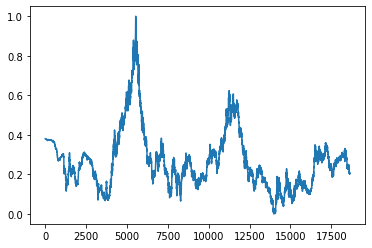

In [5]:
## visualize data
plt.plot(data_raw[:, 0])
plt.show()

In [6]:
learn_window = np.arange(100) ## learn from past 100 days
predict_window = np.arange(0, 30, 3) ## predict next 30 days, sampled 10 times

In [8]:
def generate_batches(data, label, batch_size, learn_window, predict_window, seed=None):
    """
    Randomly generate batches of windows, with replacement.
    
    - data: array, shape = (N, C)
    - label: the target to be predicted. Can be the closing price or slope of closing price etc.
    - batch_size: integer
    - learn_window: array of indices to learn from.
    - predict_window: array of indices to predict.
    - seed: seed for RNG, if any
    
    e.g. if learn_window = [0, 1, 2, ..., 9] and predict_window = [0, 1, 2, 3, 4],
    then learn on 10 days and try to predict next 5 days.
    
    returns: generator that yields random (X, y)
    - X_batch: shape = (B, len(learn_window), C)
    - y_batch: shape = (B, len(predict_window))
    """
    
    if seed != None:
        np.random.seed(seed)
        
    learn_window = np.array(learn_window)
    predict_window = np.array(predict_window)
    
    N, C = data.shape
    L, P = len(learn_window), len(predict_window)
    Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
    
    X = np.zeros((batch_size, L, C))
    y = np.zeros((batch_size, P))
    
    i = 0 # tracks index
    k = 0 # tracks batch size
    M = N - Lcap - Pcap # ceiling for i
    while True:
        
        if k == batch_size:
            k = 0
            yield X, y
            
        i = np.random.randint(0, M)
        X[k] = data[i+learn_window,:]
        y[k] = label[i+Lcap+predict_window] 
        
        k += 1

        
## short test; should not throw error
G = generate_batches(data_raw, data_raw[:,0], 7, np.arange(50), np.arange(1))

X_batch, y_batch = next(G)
print(X_batch.shape)
print(y_batch.shape)

(7, 50, 54)
(7, 1)


Now train on only the closing price of USD-Euro

In [13]:
from rnn_helper import *

In [10]:
smalldata=data_raw[:,0:1] ## Only takes on the close values of USD-EURO.

## split into training, validation, and testing sets
N, C = smalldata.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap

np.random.seed(999)
test_starts = np.random.randint(0, M, 50)
val_starts = np.random.randint(0, M, 50)

mask = np.ones(N)
for i in test_starts:
    mask[i+learn_window] = 0
for i in val_starts:
    mask[i+learn_window] = 0 
mask[np.arange(M, N)] = 0
train_starts = np.flatnonzero(mask)

print("Training size:", train_starts.shape[0])
print("Validation size:", val_starts.shape[0], "...", val_starts[:5])
print("Test size:", test_starts.shape[0], "...", test_starts[:5])

Training size: 10759
Validation size: 50 ... [ 1286  7103  9451 16503 13300]
Test size: 50 ... [12636 13157 16865  5832  8417]


In [14]:
## generate testing and validation data
G = generate_all_regression(smalldata, 50, learn_window, predict_window, val_starts)
X_val, y_val = next(G)

G = generate_all_regression(smalldata, 50, learn_window, predict_window, test_starts)
X_test, y_test = next(G)

print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(50, 100, 1)
(50, 10)
(50, 100, 1)
(50, 10)


In [18]:
## ===== model hyperparameters ======================
batch_size = 50
initial_learning_rate = 1e-4   
decay_steps = 300
decay_rate = 0.9
#L1reg = 0.001
L2reg = 0
drop_prob = 0.1

## ==================================================

_, C = smalldata.shape
L, P = len(learn_window), len(predict_window)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

inputs=layers.Input(shape=(L,C), name='inputs')

#tower11 = layers.Conv1D(20, 1, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(inputs)
# No need for convolution with kernal size 1 when the input has a single feature map
tower12 = layers.Conv1D(20, 3, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(inputs)
tower13 = layers.Conv1D(20, 5, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(inputs)
tower14 = layers.Conv1D(20, 7, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(inputs)
tower15 = layers.Conv1D(20, 9, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(inputs)
IncMod1 = layers.concatenate([tower12,tower13,tower14,tower15],axis=2, name = 'IncMod1')

pool1 = layers.AveragePooling1D(pool_size=2,strides=2)(IncMod1)

tower21 = layers.Conv1D(100, 1, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(pool1)
tower22 = layers.Conv1D(80, 3, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(pool1)
tower23 = layers.Conv1D(60, 5, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(pool1)
tower24 = layers.Conv1D(40, 7, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(pool1)
tower25 = layers.Conv1D(20, 9, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(pool1)
IncMod2 = layers.concatenate([tower21,tower22,tower23,tower24,tower25],axis=2, name= 'IncMod2')
# shape = (batch_size,50,300)

#pool2 = layers.AveragePooling1D(pool_size=2,strides=2)(IncMod2)
#Shape should be (batch_size, 25, 200)

gru = layers.GRU(200)(IncMod2)
outputs = layers.Dense(P)(gru)

model_trend = models.Model(inputs=inputs, outputs=outputs, name ='ConvGRU')
model_trend.compile(optimizer = opt,loss='mse',metrics=[keras.metrics.MeanSquaredError()])
model_trend.summary()


Model: "ConvGRU"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 100, 20)      80          inputs[0][0]                     
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 100, 20)      120         inputs[0][0]                     
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 100, 20)      160         inputs[0][0]                     
____________________________________________________________________________________________

In [19]:
## generate validation data
G = generate_batches_regression(smalldata, batch_size, learn_window, predict_window, train_starts)
model_trend.fit(G, steps_per_epoch=300, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
300/300 [==============================] - 79s 254ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 5.9572e-04 - val_mean_squared_error: 5.9572e-04
Epoch 2/30
300/300 [==============================] - 77s 256ms/step - loss: 4.1027e-04 - mean_squared_error: 4.1027e-04 - val_loss: 5.8035e-04 - val_mean_squared_error: 5.8035e-04
Epoch 3/30
300/300 [==============================] - 77s 256ms/step - loss: 4.0513e-04 - mean_squared_error: 4.0513e-04 - val_loss: 5.5511e-04 - val_mean_squared_error: 5.5511e-04
Epoch 4/30
300/300 [==============================] - 77s 257ms/step - loss: 3.8233e-04 - mean_squared_error: 3.8233e-04 - val_loss: 5.3919e-04 - val_mean_squared_error: 5.3919e-04
Epoch 5/30
300/300 [==============================] - 76s 255ms/step - loss: 3.8719e-04 - mean_squared_error: 3.8719e-04 - val_loss: 4.8438e-04 - val_mean_squared_error: 4.8438e-04
Epoch 6/30
300/300 [==============================] - 76s 255ms/step - loss: 3.5960e-04 - mean_squared_

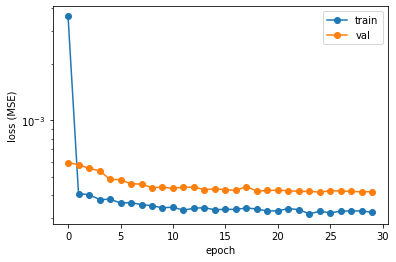

In [20]:
train_loss = model_trend.history.history['loss']
val_loss = model_trend.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [21]:
y = model_trend.predict(X_test)
ave_mse = np.mean(np.square(y_test - y))
scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
ave_mse *= scale_factor
print("Average MSE on testing data: %.3e" % ave_mse)

Average MSE on testing data: 2.652e-04


In [22]:
model_trend.save('CNNGRUsingle.h5')

Now train the model with all data

In [23]:
## split into training, validation, and testing sets
N, C = data_raw.shape
L, P = len(learn_window), len(predict_window)
Lcap, Pcap = int(np.max(learn_window))+1, int(np.max(predict_window))+1
M = N - Lcap - Pcap

np.random.seed(999)
test_starts = np.random.randint(0, M, 50)
val_starts = np.random.randint(0, M, 50)

mask = np.ones(N)
for i in test_starts:
    mask[i+learn_window] = 0
for i in val_starts:
    mask[i+learn_window] = 0 
mask[np.arange(M, N)] = 0
train_starts = np.flatnonzero(mask)

print("Training size:", train_starts.shape[0])
print("Validation size:", val_starts.shape[0], "...", val_starts[:5])
print("Test size:", test_starts.shape[0], "...", test_starts[:5])

Training size: 10759
Validation size: 50 ... [ 1286  7103  9451 16503 13300]
Test size: 50 ... [12636 13157 16865  5832  8417]


In [24]:
## generate testing and validation data
G = generate_all_regression(data_raw, 50, learn_window, predict_window, val_starts)
X_val, y_val = next(G)

G = generate_all_regression(data_raw, 50, learn_window, predict_window, test_starts)
X_test, y_test = next(G)

print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(50, 100, 54)
(50, 10)
(50, 100, 54)
(50, 10)


In [26]:
## ===== model hyperparameters ======================
batch_size = 50
initial_learning_rate = 1e-4   
decay_steps = 300
decay_rate = 0.9
L2reg = 0
drop_prob = 0.1

## ==================================================

_, C = data_raw.shape
L, P = len(learn_window), len(predict_window)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate, 
    decay_steps=decay_steps, 
    decay_rate=decay_rate)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

inputsII=layers.Input(shape=(L,C), name='inputsII')

tower11II = layers.Conv1D(20, 1, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(inputsII)
tower12II = layers.Conv1D(20, 3, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(inputsII)
tower13II = layers.Conv1D(20, 5, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(inputsII)
tower14II = layers.Conv1D(20, 7, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(inputsII)
tower15II = layers.Conv1D(20, 9, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(inputsII)
IncMod1II = layers.concatenate([tower11II,tower12II,tower13II,tower14II,tower15II],axis=2, name = 'IncMod1II')

pool1II = layers.AveragePooling1D(pool_size=2,strides=2)(IncMod1II)

tower21II = layers.Conv1D(100, 1, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(pool1II)
tower22II = layers.Conv1D(80, 3, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(pool1II)
tower23II = layers.Conv1D(60, 5, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(pool1II)
tower24II = layers.Conv1D(40, 7, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(pool1II)
tower25II = layers.Conv1D(20, 9, padding='same', activation = 'relu', kernel_regularizer = keras.regularizers.l2(L2reg))(pool1II)
IncMod2II = layers.concatenate([tower21II,tower22II,tower23II,tower24II,tower25II],axis=2, name= 'IncMod2II')
# shape = (batch_size,50,300)

#pool2 = layers.AveragePooling1D(pool_size=2,strides=2)(IncMod2)
#Shape should be (batch_size, 25, 200)

gruII = layers.GRU(200)(IncMod2II)
outputsII = layers.Dense(P)(gruII)

model_trendII = models.Model(inputs=inputsII, outputs=outputsII, name ='ConvGRUfulldata')
model_trendII.compile(optimizer = opt,loss='mse',metrics=[keras.metrics.MeanSquaredError()])
model_trendII.summary()


Model: "ConvGRUfulldata"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputsII (InputLayer)           [(None, 100, 54)]    0                                            
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 100, 20)      1100        inputsII[0][0]                   
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 100, 20)      3260        inputsII[0][0]                   
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 100, 20)      5420        inputsII[0][0]                   
____________________________________________________________________________________

In [27]:
## generate validation data
G = generate_batches_regression(data_raw, batch_size, learn_window, predict_window, train_starts)
model_trendII.fit(G, steps_per_epoch=300, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
300/300 [==============================] - 95s 308ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/15
300/300 [==============================] - 92s 307ms/step - loss: 5.8775e-04 - mean_squared_error: 5.8775e-04 - val_loss: 8.6495e-04 - val_mean_squared_error: 8.6495e-04
Epoch 3/15
300/300 [==============================] - 92s 307ms/step - loss: 4.5665e-04 - mean_squared_error: 4.5665e-04 - val_loss: 6.7662e-04 - val_mean_squared_error: 6.7662e-04
Epoch 4/15
300/300 [==============================] - 93s 309ms/step - loss: 3.9644e-04 - mean_squared_error: 3.9644e-04 - val_loss: 6.3459e-04 - val_mean_squared_error: 6.3459e-04
Epoch 5/15
300/300 [==============================] - 92s 306ms/step - loss: 3.7913e-04 - mean_squared_error: 3.7913e-04 - val_loss: 5.8981e-04 - val_mean_squared_error: 5.8981e-04
Epoch 6/15
300/300 [==============================] - 92s 308ms/step - loss: 3.5239e-04 - mean_squared_error: 3

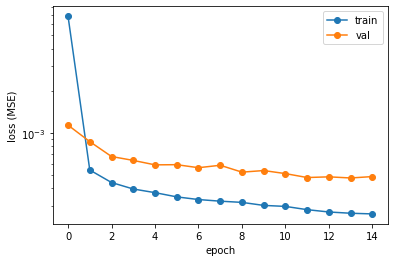

In [28]:
train_loss = model_trendII.history.history['loss']
val_loss = model_trendII.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [36]:
### Train some more because hasn't plateaued yet
### So far has trained 15+10 epochs
G = generate_batches_regression(data_raw, batch_size, learn_window, predict_window, train_starts)
model_trendII.optimizer.learning_rate = 3e-6
model_trendII.fit(G, steps_per_epoch=300, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
300/300 [==============================] - 94s 313ms/step - loss: 2.2321e-04 - mean_squared_error: 2.2321e-04 - val_loss: 4.6222e-04 - val_mean_squared_error: 4.6222e-04
Epoch 2/10
300/300 [==============================] - 94s 314ms/step - loss: 2.2367e-04 - mean_squared_error: 2.2367e-04 - val_loss: 4.5303e-04 - val_mean_squared_error: 4.5303e-04
Epoch 3/10
300/300 [==============================] - 94s 314ms/step - loss: 2.2153e-04 - mean_squared_error: 2.2153e-04 - val_loss: 4.5191e-04 - val_mean_squared_error: 4.5191e-04
Epoch 4/10
300/300 [==============================] - 95s 316ms/step - loss: 2.1750e-04 - mean_squared_error: 2.1750e-04 - val_loss: 4.5101e-04 - val_mean_squared_error: 4.5101e-04
Epoch 5/10
300/300 [==============================] - 94s 313ms/step - loss: 2.1533e-04 - mean_squared_error: 2.1533e-04 - val_loss: 4.4147e-04 - val_mean_squared_error: 4.4147e-04
Epoch 6/10
300/300 [==============================] - 94s 313ms/step - loss: 2.1719e-04 - mean_

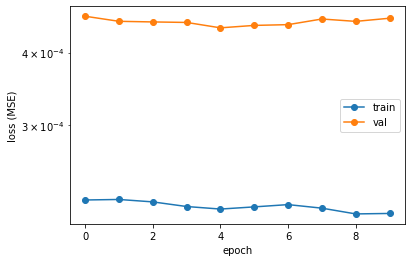

In [37]:
train_loss = model_trendII.history.history['loss']
val_loss = model_trendII.history.history['val_loss']

plt.plot(train_loss, '-o', label='train')
plt.plot(val_loss, '-o', label='val')
plt.ylabel('loss (MSE)')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()
plt.show()

In [38]:
y = model_trendII.predict(X_test)
ave_mse = np.mean(np.square(y_test - y))
scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
ave_mse *= scale_factor
print("Average MSE on testing data: %.3e" % ave_mse)

Average MSE on testing data: 3.440e-04


Compare how the models are predicting

In [39]:
model_trendII.save('CNNGRUfull.h5')

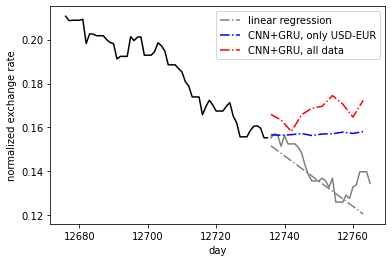

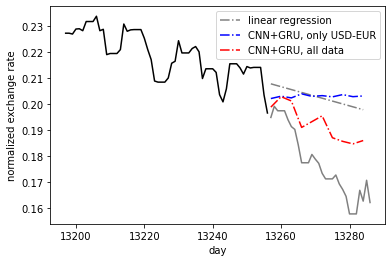

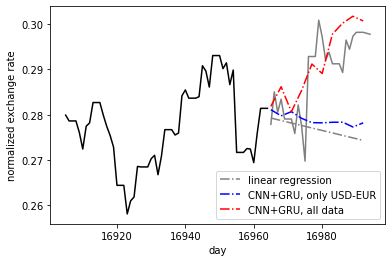

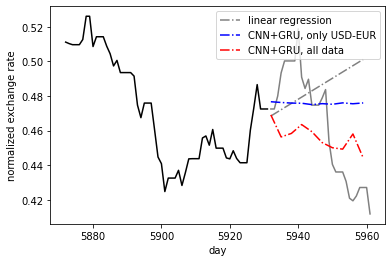

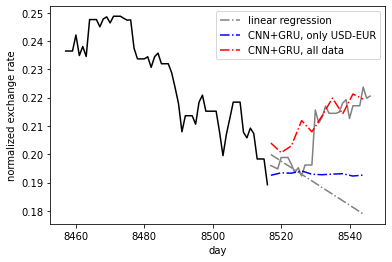

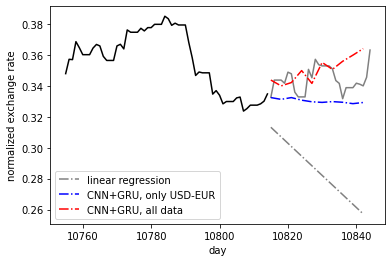

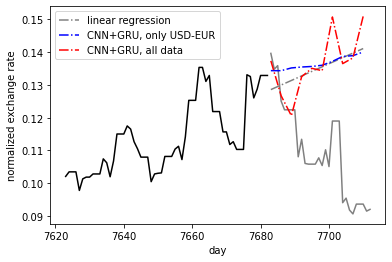

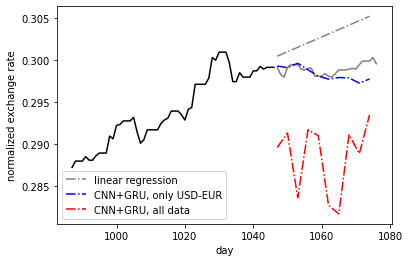

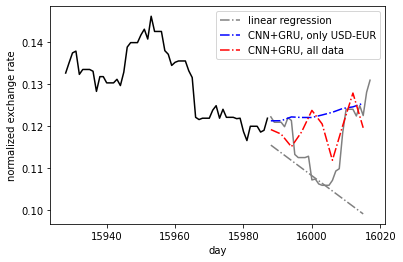

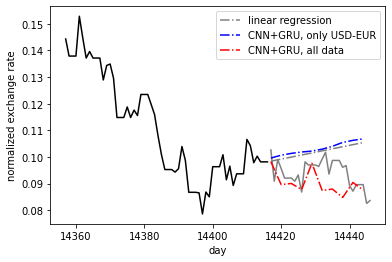

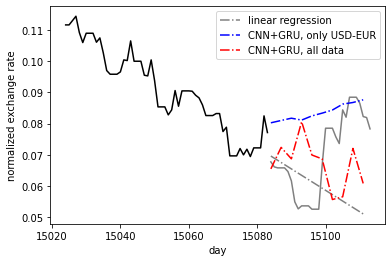

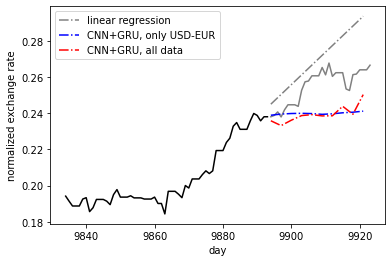

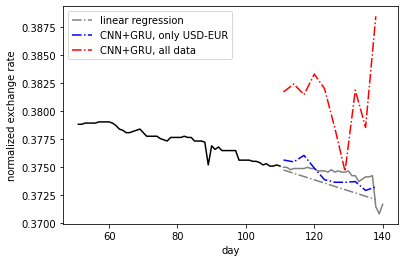

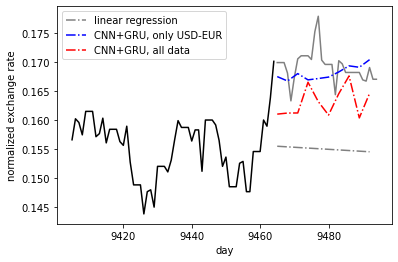

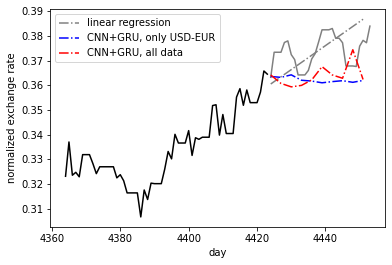

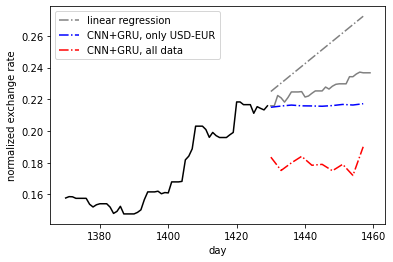

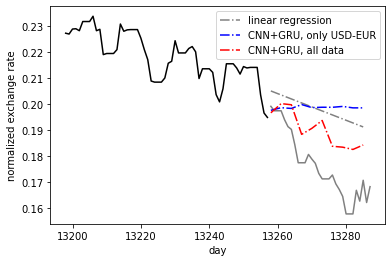

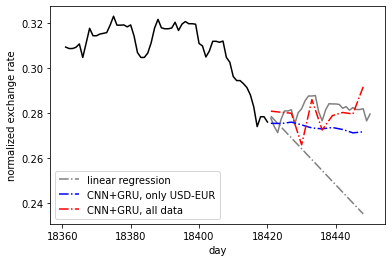

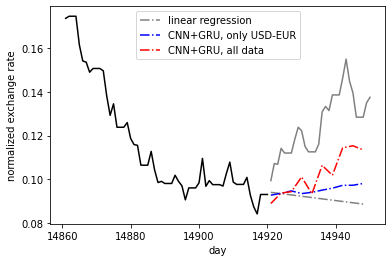

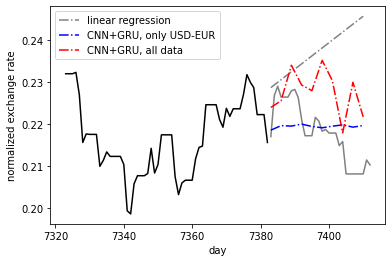

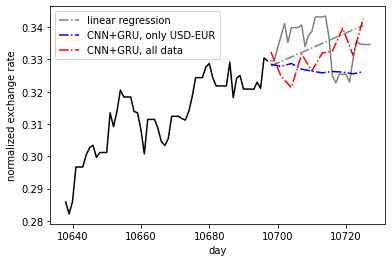

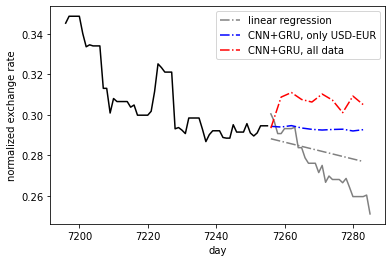

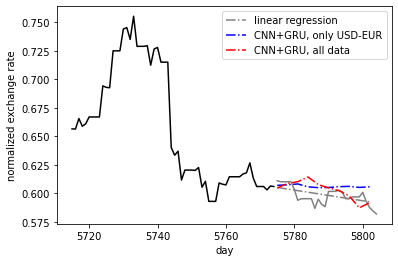

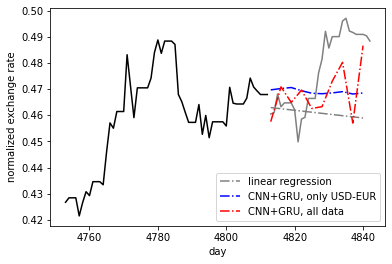

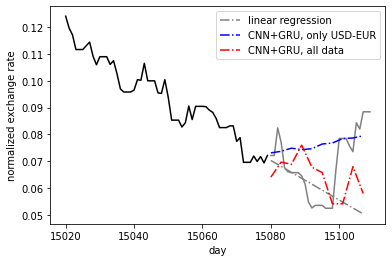

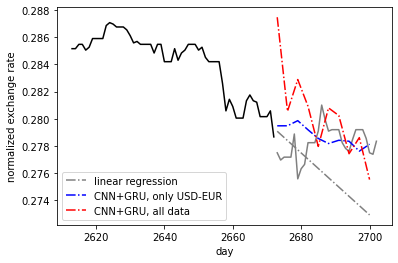

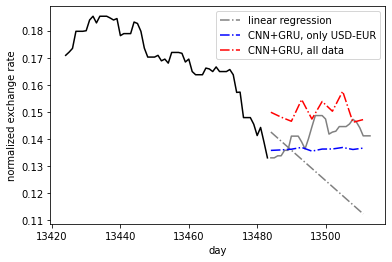

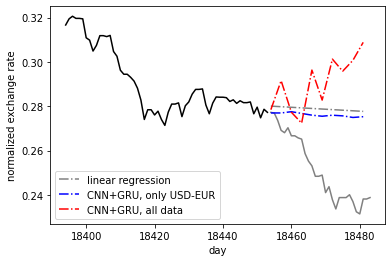

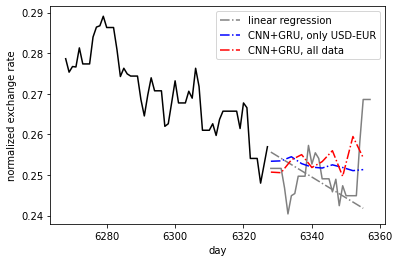

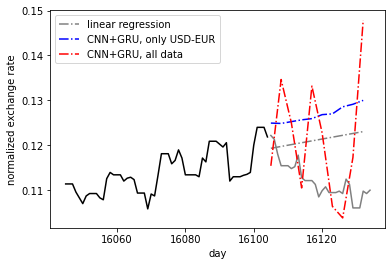

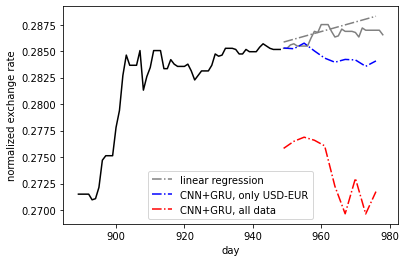

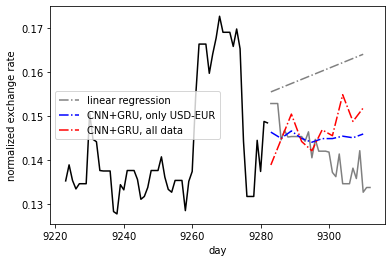

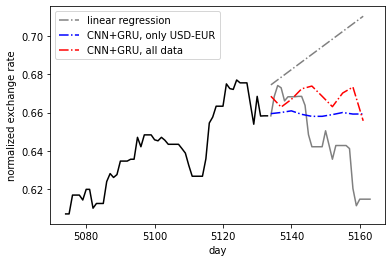

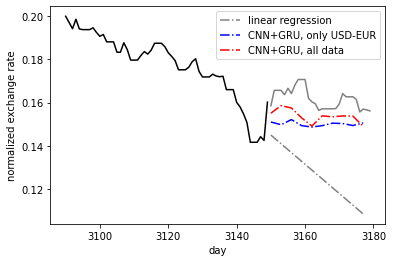

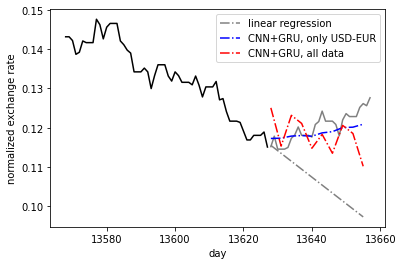

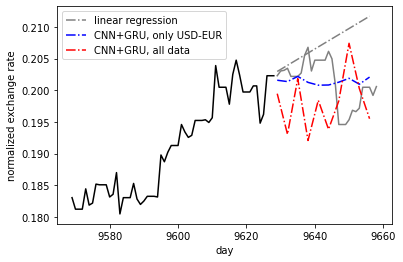

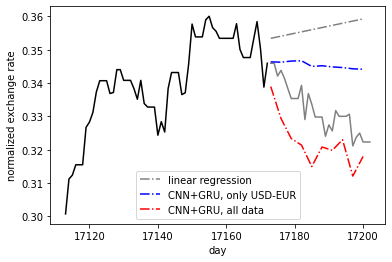

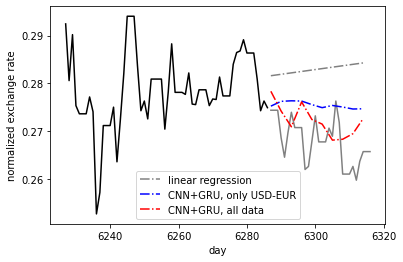

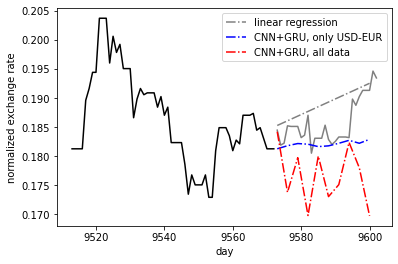

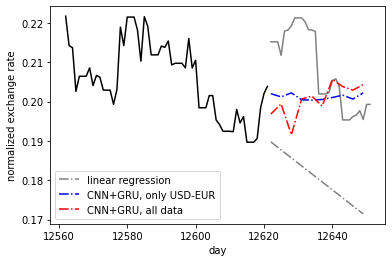

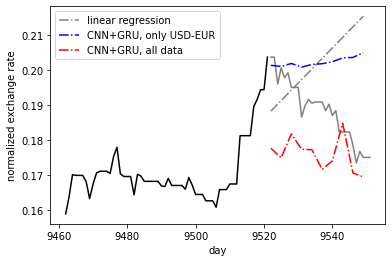

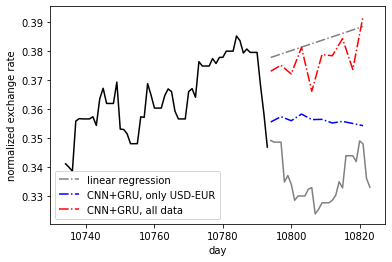

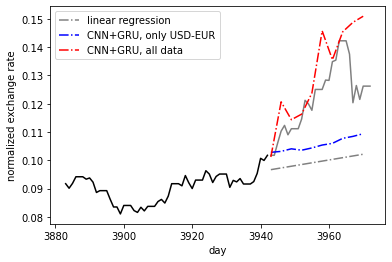

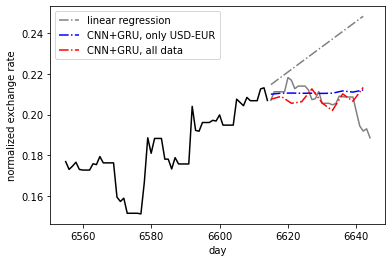

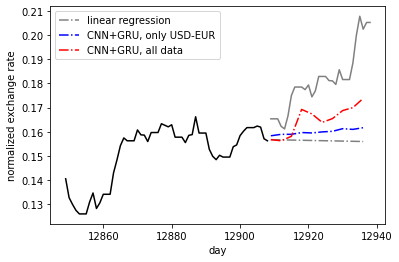

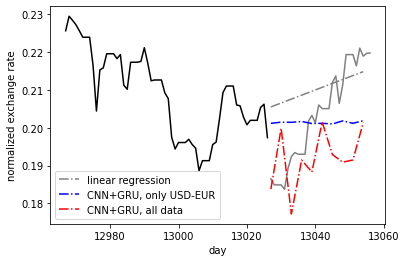

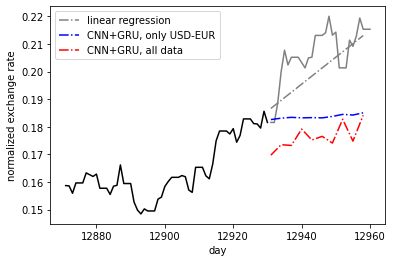

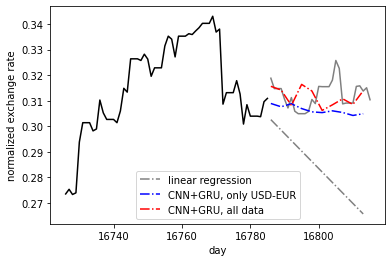

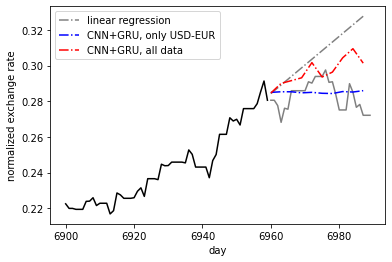

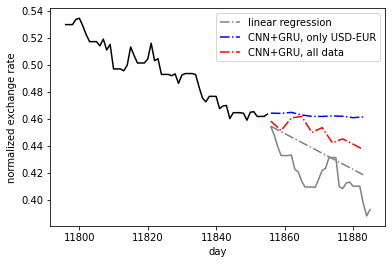

In [40]:
## visualize predictions

import sklearn.linear_model
import sklearn.preprocessing

actual_window = np.arange(30)

offset=70
lin_learn_window = np.arange(30)
lin_Lcap = 30

G = generate_all_regression(data_raw, 1, learn_window, predict_window, test_starts)
for count, i in enumerate(test_starts):
    
    if count==50:
        break
    
    X, y = next(G)
    
    x_learn = i+learn_window
    x_actual = i+Lcap+actual_window
    
    y_learn = data_raw[x_learn, 0]
    y_actual = data_raw[x_actual, 0]
    
    X_single = X[:,:,0:1]
    y1_predict = model_trend.predict(X_single)
    y2_predict = model_trendII.predict(X)

    #mse = np.mean(np.square(y[0] - y_predict[0]))
    #scale_factor = 1/scaler.scale_[0]   ## bring back to original scale
    #mse *= scale_factor
    
    
    
    ## linear regression predictions
    lin_x_learn = (offset+i+lin_learn_window).reshape(-1, 1)
    lin_x_predict = (offset+i+lin_Lcap+predict_window).reshape(-1, 1)
    lin_y_learn = data_raw[lin_x_learn[:, 0], 0:1]

    lin_model = sklearn.linear_model.LinearRegression()
    lin_model.fit(lin_x_learn, lin_y_learn)
    lin_y_predict = lin_model.predict(lin_x_predict)
    
    plt.plot(x_learn[40:], y_learn[40:], color='black')
    plt.plot(x_actual, y_actual, color='gray')
    plt.plot(x_actual[predict_window], lin_y_predict, '-.', color='gray', label='linear regression')
    plt.plot(x_actual[predict_window], y1_predict[0], '-.', color='blue', label='CNN+GRU, only USD-EUR')
    plt.plot(x_actual[predict_window], y2_predict[0], '-.', color='red', label='CNN+GRU, all data')


    #plt.title('average MSE: %.3e' % mse)
    plt.ylabel('normalized exchange rate')
    plt.xlabel('day')
    plt.legend()
    plt.show()